In [6]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from sports_3d.utils.labeling_utils import read_txt_file, read_yolo_box


# origin is center of the court
three_d_keypoints = [
    (-10.97 / 2, 0, 23.77 / 2),
    (10.97 / 2, 0, 23.77 / 2),
    (-10.97 / 2, 0, -23.77 / 2),
    (10.97 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 23.77 / 2),
    (-8.23 / 2, 0, -23.77 / 2),
    (8.23 / 2, 0, 23.77 / 2),
    (8.23 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 6.4),
    (8.23 / 2, 0, 6.4),
    (-8.23 / 2, 0, -6.4),
    (8.23 / 2, 0, -6.4),
    (0, 0, 6.4),
    (0, 0, -6.4),
    (0, 0.914, 0)
]


class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=stride,
                padding=pad,
                bias=bias,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)


class BallTrackerNet(nn.Module):
    def __init__(self, out_channels=14):
        super().__init__()
        self.out_channels = out_channels

        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        self.conv4 = ConvBlock(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = ConvBlock(in_channels=128, out_channels=256)
        self.conv6 = ConvBlock(in_channels=256, out_channels=256)
        self.conv7 = ConvBlock(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = ConvBlock(in_channels=256, out_channels=512)
        self.conv9 = ConvBlock(in_channels=512, out_channels=512)
        self.conv10 = ConvBlock(in_channels=512, out_channels=512)
        self.ups1 = nn.Upsample(scale_factor=2)
        self.conv11 = ConvBlock(in_channels=512, out_channels=256)
        self.conv12 = ConvBlock(in_channels=256, out_channels=256)
        self.conv13 = ConvBlock(in_channels=256, out_channels=256)
        self.ups2 = nn.Upsample(scale_factor=2)
        self.conv14 = ConvBlock(in_channels=256, out_channels=128)
        self.conv15 = ConvBlock(in_channels=128, out_channels=128)
        self.ups3 = nn.Upsample(scale_factor=2)
        self.conv16 = ConvBlock(in_channels=128, out_channels=64)
        self.conv17 = ConvBlock(in_channels=64, out_channels=64)
        self.conv18 = ConvBlock(in_channels=64, out_channels=self.out_channels)

        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.ups1(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.ups2(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.ups3(x)
        x = self.conv16(x)
        x = self.conv17(x)
        x = self.conv18(x)
        return F.sigmoid(x)

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)


def postprocess(heatmap, scale=2, low_thresh=250, min_radius=10, max_radius=30):
    x_pred, y_pred = None, None
    ret, heatmap = cv2.threshold(heatmap, low_thresh, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(
        heatmap,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=5,
        minRadius=10,
    )
    if circles is not None:
        x_pred = circles[0][0][0] * scale
        y_pred = circles[0][0][1] * scale
    return x_pred, y_pred


def get_keypoints(preds: torch.Tensor):
    points = []
    for kps_num in range(14):
        heatmap = (preds[kps_num] * 255).astype(np.uint8)
        x_pred, y_pred = postprocess(heatmap, scale=1, low_thresh=170, max_radius=25)
        points.append((x_pred, y_pred))
    return points


class tracknet_transform(torch.nn.Module):
    def __init__(
        self,
        size: tuple,
    ) -> None:
        self.img_size = size

    def __call__(self, img_path: str) -> torch.Tensor:
        image = Image.open(img_path).convert("RGB").resize(self.img_size)
        image = torch.from_numpy(np.array(image) / 255.0).float()
        image = image.permute(2, 0, 1)
        return image


def refine_keypoints(keypoints: list, image: np.ndarray, window_size=20):
    """
    Refines keypoints by finding the centroid of line intersections.
    Robust to thick/pixelated lines.

    Args:
        keypoints: List of (x, y) tuples from initial detection
        image: Original image as numpy array (H, W, 3)
        window_size: Size of the window to search around each keypoint

    Returns:
        List of refined (x, y) tuples
    """
    refined_keypoints = []

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    h, w = gray.shape

    for x_pred, y_pred in keypoints[:]:
        if x_pred is None or y_pred is None:
            refined_keypoints.append((None, None))
            continue

        x_pred, y_pred = int(x_pred), int(y_pred)

        x_min = max(0, x_pred - window_size)
        x_max = min(w, x_pred + window_size)
        y_min = max(0, y_pred - window_size)
        y_max = min(h, y_pred + window_size)

        window = gray[y_min:y_max, x_min:x_max]

        if window.size == 0:
            refined_keypoints.append((x_pred, y_pred))
            continue

        _, binary = cv2.threshold(window * 255, 200, 255, cv2.THRESH_BINARY)
        skeleton = binary

        corners = cv2.goodFeaturesToTrack(
            skeleton, maxCorners=5, qualityLevel=0.01, minDistance=5, blockSize=3
        )

        if corners is not None and len(corners) > 0:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            corners = corners.reshape(-1, 2)
            closest = min(
                corners, key=lambda p: (p[0] - center_x) ** 2 + (p[1] - center_y) ** 2
            )
            refined_x = closest[0] + x_min
            refined_y = closest[1] + y_min
            refined_keypoints.append((refined_x, refined_y))
        else:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            y_coords, x_coords = np.where(binary > 0)

            if len(x_coords) > 0:
                # Calculate weights based on distance to center
                distances = np.sqrt(
                    (x_coords - center_x) ** 2 + (y_coords - center_y) ** 2
                )
                weights = np.exp(-distances / 10)  # Gaussian weighting

                # Weighted centroid
                centroid_x = np.average(x_coords, weights=weights)
                centroid_y = np.average(y_coords, weights=weights)

                refined_x = centroid_x + x_min
                refined_y = centroid_y + y_min
                refined_keypoints.append((refined_x, refined_y))
            else:
                refined_keypoints.append((x_pred, y_pred))
    return refined_keypoints


def estimate_focal_range(image_width, image_height):
    """Conservative search range"""

    # Assume FOV between 30° and 90°
    min_f = image_width / (2 * np.tan(np.radians(90) / 2))  # Wide
    max_f = image_width / (2 * np.tan(np.radians(30) / 2))  # Narrow

    # Add 20% margin
    min_f *= 0.8
    max_f *= 1.2
    
    print(min_f, max_f)

    return min_f, max_f


def solve_pnp_with_focal_search(
    object_points, image_points, focal_range=(500, 2000), principal_point=None
):
    """
    object_points: Nx3 array of 3D points
    image_points: Nx2 array of 2D image points
    focal_range: (min_f, max_f) to search
    """
    if principal_point is None:
        principal_point = (image_points[:, 0].mean(), image_points[:, 1].mean())

    best_f = None
    best_error = float("inf")
    best_pose = None

    # Try different focal lengths
    for f in np.linspace(focal_range[0], focal_range[1], 500):
        camera_matrix = np.array(
            [[f, 0, principal_point[0]], [0, f, principal_point[1]], [0, 0, 1]],
            dtype=np.float32,
        )

        # Solve PnP - this returns multiple solutions for coplanar points
        success, rvec, tvec = cv2.solvePnP(
            object_points,
            image_points,
            camera_matrix,
            None,  # no distortion
            flags=cv2.SOLVEPNP_IPPE,  # Good for planar points
        )
        print(f)

        if success:
            # Compute reprojection error
            projected, _ = cv2.projectPoints(
                object_points, rvec, tvec, camera_matrix, None
            )
            error = np.mean(np.linalg.norm(projected.squeeze() - image_points, axis=1))

            if error < best_error:
                best_error = error
                best_f = f
                best_pose = (rvec, tvec)

    return best_f, best_pose, best_error

def solve_pnp_with_focal_search(
    object_points, image_points, focal_range=(500, 2000), principal_point=None
):
    """
    object_points: Nx3 array of 3D points
    image_points: Nx2 array of 2D image points
    focal_range: (min_f, max_f) to search
    """
    if principal_point is None:
        principal_point = (image_points[:, 0].mean(), image_points[:, 1].mean())

    best_f = None
    best_error = float("inf")
    best_pose = None

    # Check if points are coplanar (all Y values the same, or all on one plane)
    y_values = object_points[:, 1]
    is_coplanar = np.allclose(y_values, y_values[0], atol=0.01)
    
    # Use IPPE for coplanar, SQPNP or ITERATIVE for non-coplanar
    if is_coplanar:
        solver_flag = cv2.SOLVEPNP_IPPE
    else:
        # SQPNP is robust and works well with 4+ points
        solver_flag = cv2.SOLVEPNP_SQPNP

    # Try different focal lengths
    for f in np.linspace(focal_range[0], focal_range[1], 50):
        camera_matrix = np.array(
            [[f, 0, principal_point[0]], [0, f, principal_point[1]], [0, 0, 1]],
            dtype=np.float32,
        )

        try:
            success, rvec, tvec = cv2.solvePnP(
                object_points.astype(np.float32),
                image_points.astype(np.float32),
                camera_matrix,
                None,
                flags=solver_flag,
            )
        except cv2.error:
            continue

        if success:
            projected, _ = cv2.projectPoints(
                object_points, rvec, tvec, camera_matrix, None
            )
            error = np.mean(np.linalg.norm(projected.squeeze() - image_points, axis=1))

            if error < best_error:
                best_error = error
                best_f = f
                best_pose = (rvec, tvec)

    return best_f, best_pose, best_error


def get_points(keypoints: list):
    points_2d = []
    points_3d = []
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            points_2d.append(keypoint)
            points_3d.append(three_d_keypoints[idx])
    return np.array(points_2d), np.array(points_3d)


def plot_keypoints(keypoints: list, image: np.ndarray):
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            # plot text
            cv2.putText(
                image,
                str(idx),
                (int(keypoint[0]), int(keypoint[1])),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                1,
            )
            cv2.circle(image, (int(keypoint[0]), int(keypoint[1])), 25, (0, 0, 255), -1)
    return image


def solve_planar_pnp(object_points, image_points, camera_matrix):
    """Handles the planar ambiguity explicitly"""

    # IPPE returns both possible solutions
    success, rvecs, tvecs, reprojErrors = cv2.solvePnPGeneric(
        object_points, image_points, camera_matrix, None, flags=cv2.SOLVEPNP_IPPE
    )

    # You'll get 2 solutions - pick based on physical constraints
    # e.g., camera should be in front of points, not behind
    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        print(f"Solution {i}:")
        print(f"  Rotation: {rvec.ravel()}")
        print(f"  Translation: {tvec.ravel()}")
        print(f"  Reprojection error: {reprojErrors[i]}")

    return rvecs, tvecs, reprojErrors

def solve_pnp_generic(object_points, image_points, camera_matrix):
    """Handles both planar and non-planar cases"""
    
    y_values = object_points[:, 1]
    is_coplanar = np.allclose(y_values, y_values[0], atol=0.01)
    
    if is_coplanar:
        # IPPE returns both ambiguous solutions
        success, rvecs, tvecs, reprojErrors = cv2.solvePnPGeneric(
            object_points.astype(np.float32), 
            image_points.astype(np.float32), 
            camera_matrix, 
            None, 
            flags=cv2.SOLVEPNP_IPPE
        )
    else:
        # Non-planar: unique solution, no ambiguity!
        success, rvec, tvec = cv2.solvePnP(
            object_points.astype(np.float32),
            image_points.astype(np.float32),
            camera_matrix,
            None,
            flags=cv2.SOLVEPNP_SQPNP,
        )
        if success:
            projected, _ = cv2.projectPoints(object_points, rvec, tvec, camera_matrix, None)
            error = np.mean(np.linalg.norm(projected.squeeze() - image_points, axis=1))
            rvecs, tvecs, reprojErrors = [rvec], [tvec], [error]
        else:
            return None, None, None

    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        print(f"Solution {i}:")
        print(f"  Rotation: {rvec.ravel()}")
        print(f"  Translation: {tvec.ravel()}")
        print(f"  Reprojection error: {reprojErrors[i]}")

    return rvecs, tvecs, reprojErrors


def get_camera_pose_in_world(rvec, tvec):
    """Get camera position in world coordinates"""
    R, _ = cv2.Rodrigues(rvec)  # Convert axis-angle to rotation matrix

    # Camera position in world frame
    camera_position = -R.T @ tvec

    # Camera orientation in world frame
    R_world = R.T  # Rotation from camera to world

    return camera_position, R_world


def rvec_tvec_to_extrinsic(rvec, tvec):
    R, _ = cv2.Rodrigues(rvec)
    extrinsic_3x4 = np.hstack([R, tvec.reshape(3, 1)])

    return extrinsic_3x4


def select_valid_solution(rvecs, tvecs, reprojErrors):
    """Select the solution where camera is above the court (positive Y)"""

    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        camera_pos, _ = get_camera_pose_in_world(rvec, tvec)

        # For tennis court: camera should be above ground (Y > 0)
        # and in front of court (reasonable Z value)
        if camera_pos[2] < 0:  # camera is behind the court
            print(f"Selected solution {i}: Camera at {camera_pos.ravel()}")
            return rvec, tvec, reprojErrors[i]

    # Fallback to lowest reprojection error
    best_idx = np.argmin(reprojErrors)
    return rvecs[best_idx], tvecs[best_idx], reprojErrors[best_idx]


def get_2d_and_3d_keypoints(file_path: str):
    keypoints = read_txt_file(file_path)
    keypoints = [tuple(map(float, line.split())) for line in keypoints]
    points_3d = []

    for keypoint in keypoints:
        points_3d.append(three_d_keypoints[int(keypoint[0])])
    points_2d = []
    for keypoint in keypoints:
        points_2d.append((keypoint[1], keypoint[2]))
    return np.array(points_2d), np.array(points_3d)


def estimate_depth_in_camera_plane(
    object_width_px: float, focal_px: float, object_width_m: float
):
    return object_width_m * focal_px / object_width_px


def estimate_camera_plane_coordinates(
    image_width_px: float,
    image_height_px: float,
    x_coord_px: float,
    y_coord_px: float,
    object_width_m: float,
    object_width_px: float,
    focal_px: float,
) -> np.ndarray:
    depth = estimate_depth_in_camera_plane(object_width_px, focal_px, object_width_m)
    print(depth)
    x_coord_m = (x_coord_px - image_width_px / 2) * depth / focal_px
    y_coord_m = (y_coord_px - image_height_px / 2) * depth / focal_px
    return np.array([x_coord_m, y_coord_m, depth])


def camera_plane_to_world(
    camera_pos: np.ndarray,
    R_world: np.ndarray,
    camera_plane_coordinates: np.ndarray,
) -> np.ndarray:
    return camera_pos + R_world @ camera_plane_coordinates

1536.0000000000002 8598.645060638693
[[  1.77822315]
 [ -1.91471598]
 [-22.14961494]]


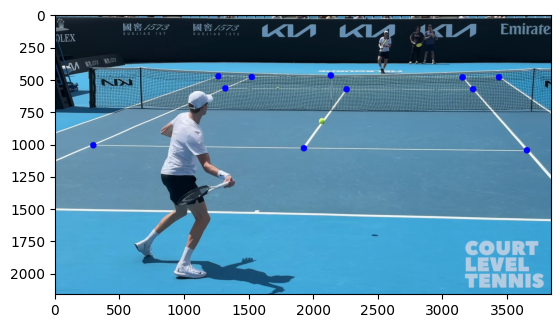

In [7]:
frame_name = "frame_004200_t70.000s"
# frame_name = "frame_004273_t71.217s"
keypoints_path = "/Users/derek/Desktop/sports_3d/data/sinner_ruud_keypoints/frame_004200_t70.000s_keypoints.txt"
image = cv2.imread(
    f"/Users/derek/Desktop/sports_3d/data/sinner_ruud_Frames/{frame_name}.png"
)
keypoints_2d, keypoints_3d = get_2d_and_3d_keypoints(keypoints_path)
plt.imshow(plot_keypoints(keypoints_2d, cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
min_f, max_f = estimate_focal_range(image.shape[1], image.shape[0])
best_f, best_pose, best_error = solve_pnp_with_focal_search(
    keypoints_3d,
    keypoints_2d,
    focal_range=(min_f, max_f),
    principal_point=(image.shape[1] / 2, image.shape[0] / 2),
)
rvec, tvec = best_pose
camera_pos, R_world = get_camera_pose_in_world(rvec, tvec)
extrinsic_matrix = rvec_tvec_to_extrinsic(rvec, tvec)


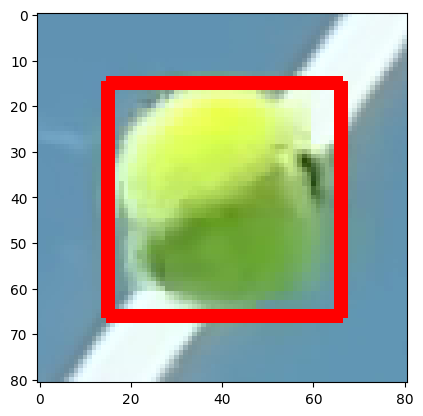

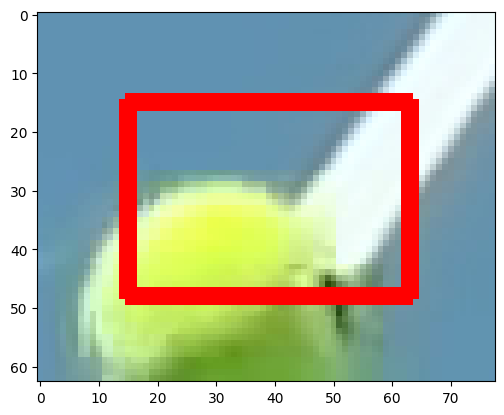

In [26]:
from sports_3d.utils.labeling_utils import yolo_to_x1x2y1y2, read_yolo_box

frame_name = "frame_004202_t70.033s"
box_path = f"/Users/derek/Desktop/sports_3d/data/sinner_ruud_bbox/{frame_name}_bbox.txt"
image = cv2.imread(f"/Users/derek/Desktop/sports_3d/data/sinner_ruud_Frames/{frame_name}.png")
yolo_box = read_yolo_box(box_path)
yolo_box_refined = read_yolo_box(box_path.replace("bbox.txt", "bbox_refined.txt"))
x1, y1, x2, y2 = yolo_to_x1x2y1y2(yolo_box[0], image.shape[1], image.shape[0])
x1_refined, y1_refined, x2_refined, y2_refined = yolo_to_x1x2y1y2(yolo_box_refined[0], image.shape[1], image.shape[0])
plotted_rectangle = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 2)
plotted_rectangle_refined = cv2.rectangle(image.copy(), (x1_refined, y1_refined), (x2_refined, y2_refined), (0, 0, 255), 2)
x1 -= 15
x2 += 15
y1 -= 15
y2 += 15
x1_refined -= 15
x2_refined += 15
y1_refined -= 15
y2_refined += 15
plotted_rectangle = plotted_rectangle[y1:y2, x1:x2]
plotted_rectangle_refined = plotted_rectangle_refined[y1_refined:y2_refined, x1_refined:x2_refined]

plt.imshow(cv2.cvtColor(plotted_rectangle, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(plotted_rectangle_refined, cv2.COLOR_BGR2RGB))
plt.show()

    


In [15]:
image_height, image_width, _ = image.shape
cx, cy, w, h = yolo_box[0]
cx = cx * image_width
cy = cy * image_height
w = w * image_width
h = h * image_height
print(w, h, image_width, image_height, best_f)
camera_plane_coordinates = estimate_camera_plane_coordinates(
    image_width_px=image_width,
    image_height_px=image_height,
    x_coord_px=cx,
    y_coord_px=cy,
    object_width_m=0.066,
    object_width_px=w+3,
    focal_px=best_f,
)
P_world = R_world @ camera_plane_coordinates.reshape(3, 1) + camera_pos
print(P_world)

45.688320000000004 48.438 3840 2160 6724.882085367203
9.115989576847905
[[  0.9528908 ]
 [ -0.92503371]
 [-13.116642  ]]
